# Домашнее задание №1 "Анализ данных фондового рынка"
#### Выполнили: Мельников, Малышева, Селивановская

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math
import seaborn as sns

## 1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка. 

Для начала нами был скачан список компаний, торгующихся на фондовой бирже NASDAQ. Затем по полученному списку тикеров мы подгрузили данные по дневным ценам активов с помощью библиотеки yfinance. 

Датасет по индексу рынка был скачан с https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC

In [2]:
nasdaq = pd.read_excel("NASDAQ.xlsx")
tickers = nasdaq['Symbol']
tickers_list = list()
for ticker in tickers:
    tickers_list.append(ticker)

In [3]:
data = yf.download(tickers_list,'2019-01-02','2019-12-31')
data.to_pickle('ticker_data')

[*********************100%***********************]  5013 of 5013 completed

2013 Failed downloads:
- NVOS: Data doesn't exist for startDate = 1546376400, endDate = 1577739600
- DHBCU: Data doesn't exist for startDate = 1546376400, endDate = 1577739600
- EDOC: Data doesn't exist for startDate = 1546376400, endDate = 1577739600
- COOLU: Data doesn't exist for startDate = 1546376400, endDate = 1577739600
- IKT: Data doesn't exist for startDate = 1546376400, endDate = 1577739600
- CRDL: No data found for this date range, symbol may be delisted
- GAMCW: No data found for this date range, symbol may be delisted
- RVPHW: No data found for this date range, symbol may be delisted
- SWETW: No data found for this date range, symbol may be delisted
- YSACU: Data doesn't exist for startDate = 1546376400, endDate = 1577739600
- WGRO: Data doesn't exist for startDate = 1546376400, endDate = 1577739600
- GPCOR: No data found for this date range, symbol may be delisted
- RCHGU: Data doesn't exist for s

Следует уточнить, что все дальнейшие расчеты будут проводиться по скорректированной цене закрытия (Adj Close). Столбцы, которые не будут использоваться нами в работе удалим.

In [4]:
#stock data
data = pd.read_pickle('ticker_data')
data = data.drop(columns = ['Low', 'High', 'Open', 'Close'])
#market index data
index = pd.read_csv('index_ixic.csv', sep=",")
index = index.drop(columns = ['Low', 'High', 'Open', 'Close'])

Проведем предобработку данных: создадим два фрейма данных adj_close и volume, к основным данным в этих фреймах добавим данные по индексу рынка, удалим все пропущенные значения. 

В итоге получим данные о 250-ти торговых днях.

In [5]:
adj_close = data['Adj Close'] # adjusted closing price
volume = data['Volume'] # sales volume


adj_close.reset_index(level=0, inplace=True) # set index from date to int
volume.reset_index(level=0, inplace=True)

for i in range(0, len(adj_close['Date'])):
    volume.loc[i, 'Date'] = str(volume['Date'][i].date())
    adj_close.loc[i, 'Date'] = str(adj_close['Date'][i].date())


adj_indexes = set(adj_close['Date'].to_list())
ind_indexes = set(index['Date'].to_list())
diff = adj_indexes.difference(ind_indexes)
diff, adj_close.shape, index.shape

C:\Users\Katya\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


({'2019-11-28'}, (252, 5014), (251, 3))

In [6]:
adj_close = adj_close.loc[adj_close['Date'] != '2019-11-28']
volume = volume.loc[volume['Date'] != '2019-11-28']

#handling missing values
adj_close = adj_close.dropna(axis=1, how='any')
volume = volume.dropna(axis=1, how='any')

#add the index data to the main data
adj_close['IXIC'] = index['Adj Close']
volume['IXIC'] = index['Volume']

#delete last day as ixic is nan
adj_close = adj_close.loc[adj_close['Date'] != '2019-12-30']
volume = volume.loc[volume['Date'] != '2019-12-30']

#reindex after drop
adj_close.reset_index(drop=True, inplace=True)

In [7]:
#reduce the number of tickers
tickers_to_delete = adj_close.columns.to_list()
tickers_to_delete.remove('Date')
tickers_to_delete.remove('IXIC')
tickers_to_delete = tickers_to_delete[::2]
adj_close.drop(tickers_to_delete, inplace=True, axis=1) 
volume.drop(tickers_to_delete, inplace=True, axis=1) 

## 2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E). 

Итак, необходимо из данных по ценам закрытия получить данные по доходностям. Для этого использовалась логарифмическая доходность (отношение цены закрытия текущего дня к предыдущему).

In [8]:
# calculate logarithmic returns
log_returns = pd.DataFrame(index = adj_close.index, columns = adj_close.columns)
log_returns['Date'] = adj_close['Date']
tickers = adj_close.columns.to_list()
tickers.remove('Date')


num_days=len(log_returns['AADR'])
for ticker in tickers:
    for i in range(1, num_days):
        log_returns.loc[i, ticker] = np.log(adj_close.loc[i, ticker]/adj_close.loc[i-1, ticker])
#droping first day
log_returns = log_returns.dropna(axis=0, how='any')
log_returns.reset_index( drop=True, inplace=True) 

In [9]:
log_returns

,Date,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,...,ZBRA,ZEST,ZG,ZION,ZIOP,ZKIN,ZNGA,ZSAN,ZYNE,IXIC
0,2019-01-03,-0.0112208,-0.0530182,-0.104924,-0.0239004,-0.0600914,-0.0250564,-0.0592194,-0.0192684,-0.0501898,...,-0.0617774,0.057894,-0.0109327,-0.00554689,-0.0275246,-0.0651332,-0.0151902,0.0294759,-0.013532,-0.03084
1,2019-01-04,0.0381305,0.0313751,0.0418032,0.0324233,0.0586679,0.0362211,0.083912,0.0154443,0.0525181,...,0.0406259,0.117783,0.0259755,0.030251,0.041008,0.126881,0.0251902,0.0911522,0.0861027,0.0417198
2,2019-01-07,0.0117576,0.00896869,-0.00222819,0.00595423,0.0674723,0.00432952,0.0240975,0.00763362,0.0713467,...,0.0150525,-0.0454623,0.00550252,0.00398099,0.013304,0.0178047,0.0123611,0.0298529,0,0.0124774
3,2019-01-08,0.00689408,0.0208275,0.0188837,0.00265223,-0.0269922,0.0114338,-0.0363676,-0.044711,0.0176008,...,0.00667488,-0.0723207,0.0264389,0.00907301,-0.0358783,-0.0923734,0.0170527,0.0182154,0.0295588,0.0107184
4,2019-01-09,0.0166807,0.00684725,0.0168391,0.0169942,0,0.0549296,-0.0584665,0.0801956,0.00424631,...,0.0245163,-0.0645385,0.0233039,0.00853228,0.0314632,0.166061,0.0309181,0.0143371,0.0357607,0.00867332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2019-12-20,0.0082443,-0.0160575,-0.00207335,0.00315572,-0.471605,-0.0393647,0.237081,-0.00884961,-0.0333793,...,-0.00253154,0.0151136,-0.0202348,0.00271527,-0.0336999,-0.0540673,-0.00318979,-0.00722024,-0.00801932,0.00231558
245,2019-12-23,0.00242295,0.00269419,0.0161868,0.000410782,0.1514,0.0453082,-0.0496556,-0.112795,0.0155444,...,0.0166533,0,0.0127797,-0.00563265,0,0.0389154,0.00318979,0.0215062,-0.0244511,0.000807831
246,2019-12-24,0.00519865,-0.00269419,0.000950071,-0.00301693,-0.00829886,0.0108538,0,-0.0100002,0.0203569,...,-0.00939235,0,0.0135138,0.00369387,0.0433993,0.00760468,0.00793021,-0.0142859,-0.00995032,0.00773397
247,2019-12-26,0.00554022,0.0431215,0.0196462,0.00616143,0,-0.00751516,-0.0484266,0.00501258,-0.0126744,...,0.000353794,0,0.0137749,0.00251982,-0.0454175,-0.00760468,-0.00475056,0.00716848,-0.0219049,-0.00174935


Для вычисления ожидаемой доходности и риска использовались встроенные функции numpy (mean и std).

In [10]:
#calculate the estimates of the mathematical expectation and std for each stock
ListOfStats = ['Mean', 'Std']

stats = pd.DataFrame(columns = ListOfStats, index = tickers)

for ticker in tickers:
    mean = np.mean(log_returns[ticker])
    std = np.std(log_returns[ticker], ddof = 1)

    stats['Mean'][ticker] = mean
    stats['Std'][ticker] = std

stats

,Mean,Std
AADR,0.00123549,0.00851074
AAOI,-0.00128906,0.0360411
AAPL,0.00249805,0.0166611
AAXJ,0.000701248,0.00977426
ABEO,-0.00289376,0.0743709
...,...,...
ZKIN,-0.000788889,0.0445391
ZNGA,0.00181245,0.0156228
ZSAN,-0.00214996,0.0820995
ZYNE,0.00175588,0.0539614


<b>Теперь построим "карту" активов в системе координат (σ, E):</b>

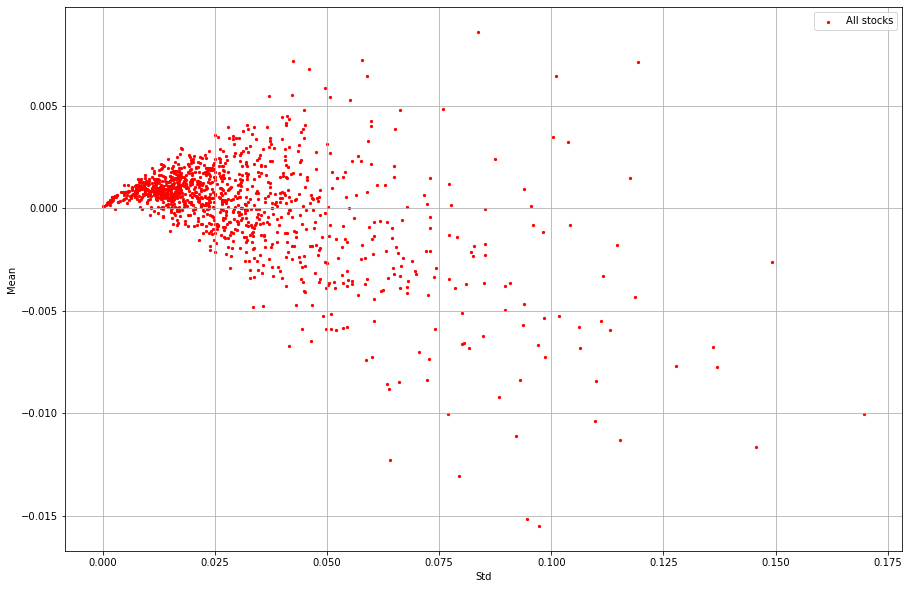

In [11]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", marker=".", label='All stoсks', figsize=(15,10), grid='On')
plt.legend()
plt.show()

<b> По графику видно, что: </b>
<ul>
<li> большинство активов обладают невысокой доходностью и степенью риска;</li> 
<li> есть активы с отрицательной доходностью, а вот безрисковых активов (std=0) нет;</li>
<li> c увеличением доходности растет риск и уменьшается плотность точек на карте активов;</li>
<li> активы расположены на графике симметрично относительно доходности равной нулю;</li>
<li> ожидаемая доходность большинства активов близка к нулю.</li>
</ul>

## 3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат   (σ, E).  Дайте характеристику этому портфелю.

In [12]:
log_returns_without_date = log_returns.drop(columns = ['Date'])

In [13]:
#equally weighted portfolio return
# eqw - equally weighted 
returns_eqw = []
for index, row in log_returns_without_date.iterrows():
    returns_eqw.append(np.sum(row)/len(tickers))

mean_eqw = np.round(np.mean(returns_eqw), 5)
std_eqw = np.round(np.std(returns_eqw), 5)

Отметим портфель с равными долями капитала на карте активов:

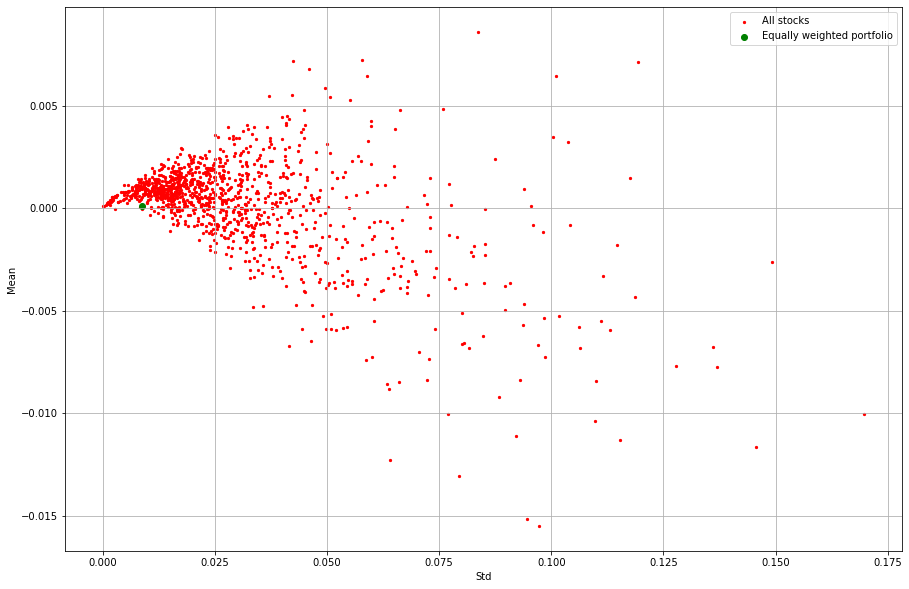

Ожидаемая доходность портфеля с равными долями капитала:  0.001181503788172686
Риск портфеля с равными долями капитала:  0.009953785236853668


In [14]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", label='All stoсks', marker = ".", figsize=(15,10), grid='On')
plt.scatter(std_eqw, mean_eqw, color="green", label='Equally weighted portfolio')
plt.legend()
plt.show()
print("Ожидаемая доходность портфеля с равными долями капитала: ", stats['Mean']['IXIC'])
print("Риск портфеля с равными долями капитала: ", stats['Std']['IXIC'])

Можно сделать вывод, что вкладываться в портфель в равными долями не является рациональным, так как существует активы с меньшим риском и большей доходностью 

## 4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка.

Рассмотрим индекс NASDAQ Composite (IXIC). Это  фондовый индекс, составленный из обыкновенных акций и подобных финансовых инструментов всех компаний, торгующихся на бирже NASDAQ. Включает в себя более 3000 корпораций. 

В силу специфики биржи NASDAQ индекс считается важным показателем динамики курсов ценных бумаг высокотехнологичных и быстро растущих компаний.

Отметим индекс рынка на карте активов:

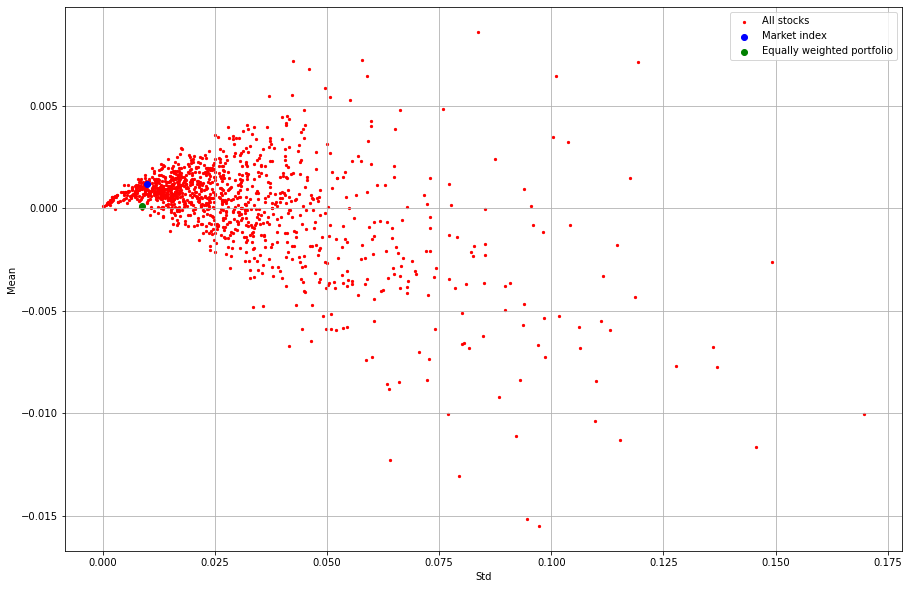

Ожидаемая доходность индекса IXIC:  0.001181503788172686
Риск индекса IXIC:  0.009953785236853668


In [15]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", label='All stoсks', marker=".", grid="On", figsize=(15,10))
plt.scatter(stats['Std']['IXIC'], stats['Mean']['IXIC'], color="blue", label='Market index')
plt.scatter(std_eqw, mean_eqw, color="green", label='Equally weighted portfolio')
plt.legend()
plt.show()
print("Ожидаемая доходность индекса IXIC: ", stats['Mean']['IXIC'])
print("Риск индекса IXIC: ", stats['Std']['IXIC'])

## 5. Задайте уровень риска и оцените VaR (Value at Risk = Сумма под Риском) для активов вашего рынка. Какой из активов наиболее предпочтителен по этой характеристике?  Где он расположен на карте активов? Дайте характеристику VaR портфеля с равными долями и индекса рынка.

Рассмотрим значение суммы под риском для двух уровней доверия (90% и 95%).

In [16]:
losses = -log_returns.drop(['Date'], axis=1) # losses for every ticker and market index
losses_eqw = [-x for x in returns_eqw] # losses for equally weighted portfolio

VaR1 = np.quantile(losses, q=0.9, axis=0)
VaR1 = pd.DataFrame(columns = tickers, data=[VaR1])

VaR2 = np.quantile(losses, q=0.95, axis=0)
VaR2 = pd.DataFrame(columns = tickers, data=[VaR2])

In [17]:
print("VaR для всех активов при γ = 0.9")
VaR1.drop(['IXIC'], axis=1)

VaR для всех активов при γ = 0.9


,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,ACGL,...,YY,ZBRA,ZEST,ZG,ZION,ZIOP,ZKIN,ZNGA,ZSAN,ZYNE
0,0.009901,0.040697,0.014789,0.010906,0.070734,0.031014,0.060819,0.052681,0.049744,0.012701,...,0.031511,0.023811,0.072353,0.027878,0.018984,0.048319,0.050017,0.017538,0.056232,0.049166


In [18]:
print("VaR для всех активов при γ = 0.95")
VaR2.drop(['IXIC'], axis=1)

VaR для всех активов при γ = 0.95


,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,ACGL,...,YY,ZBRA,ZEST,ZG,ZION,ZIOP,ZKIN,ZNGA,ZSAN,ZYNE
0,0.012909,0.055037,0.020887,0.015551,0.085274,0.041589,0.085588,0.069905,0.081211,0.017916,...,0.048678,0.03267,0.101173,0.036926,0.023704,0.066251,0.066634,0.023869,0.07582,0.06643


In [19]:
print(f"При γ = 0.9 наиболее предпочтительным является актив {VaR1.loc[0].idxmin()}, VaR={VaR1.loc[0].min()}")
print(f"При γ = 0.95 наиболее предпочтительным является актив {VaR2.loc[0].idxmin()}, VaR={VaR2.loc[0].min()}")

При γ = 0.9 наиболее предпочтительным является актив SHV, VaR=9.052570779485673e-05
При γ = 0.95 наиболее предпочтительным является актив FTSM, VaR=0.00016654477849707976


In [20]:
VaR = np.quantile(losses["IXIC"], q=0.9)
print(f"При γ = 0.9 VaR индекса рынка составляет {VaR}")

VaR = np.quantile(losses["IXIC"], q=0.95)
print(f"При γ = 0.95 VaR индекса рынка составляет {VaR}")

При γ = 0.9 VaR индекса рынка составляет 0.01113094471865204
При γ = 0.95 VaR индекса рынка составляет 0.015540042124617043


In [21]:
VaR = np.quantile(losses_eqw, q=0.90)
print(f"При γ = 0.9 VaR портфеля с равными долями составляет {VaR}")

VaR = np.quantile(losses_eqw, q=0.95)
print(f"При γ = 0.95 VaR портфеля с равными долями составляет {VaR}")

При γ = 0.9 VaR портфеля с равными долями составляет 0.010300584355417353
При γ = 0.95 VaR портфеля с равными долями составляет 0.014085966774029537


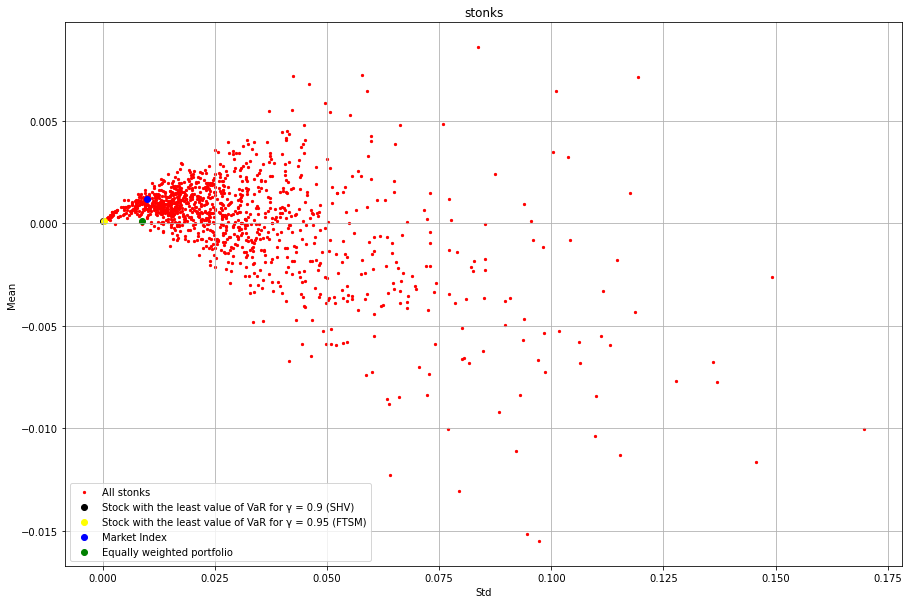

In [22]:
stats.plot(title = "stonks", x='Std', y='Mean', color="red", kind="scatter", label="All stonks", marker = ".", figsize=(15,10), grid='On')
plt.scatter(stats['Std'][VaR1.loc[0].idxmin()], stats['Mean'][VaR1.loc[0].idxmin()], color="black", label=f"Stock with the least value of VaR for γ = 0.9 ({VaR1.loc[0].idxmin()})")
plt.scatter(stats['Std'][VaR2.loc[0].idxmin()], stats['Mean'][VaR2.loc[0].idxmin()], color="yellow", label=f"Stock with the least value of VaR for γ = 0.95 ({VaR2.loc[0].idxmin()})")
plt.scatter(stats['Std']["IXIC"], stats['Mean']["IXIC"], color="blue", label="Market Index")
plt.scatter(std_eqw, mean_eqw, color="green", label='Equally weighted portfolio')
plt.legend()
plt.show()

## 6. Выберите несколько интересных (значимых)  активов рынка.   Можно ли считать наблюдаемые доходности (объемы продаж) конкретного актива повторной выборкой из некоторого распределения (белый шум)?  Поищите научные подходы к ответу на этот вопрос (проверка гипотезы о случайности, Ивченко Г.И. Медведев Ю.И. Введение в математическую статистику)

Были рассмотрены следующие активы: ACER, AAPL, HIFS, PATK. Необходимо проверить, являются ли наблюдаемые доходности конкретного актива повторной выборкой из некоторого распределения

$H_0$: наблюдения представляют собой независимые исходы случайной величины

$H_1$: наблюдения являются повторной выборкой из некоторого распределения 


### Критерий инверсий
Вычисляем статистику $A$, которая представляет из себя количество инверсий (неравенств вида $X_i > X_j$ при $i < j$)

Если временной ряд длины $n$ состоит из независимых случайных величин, то число инверсий является случайной
величиной с математическим ожиданием и дисперсией следующего вида:

$E(A) = \frac{n(n-1)}{4}$

$D(A) = \frac{n(2n+5)(n-1)}{72}$

Где $n$ - число наблюдений 

При больших значениях $n$ ($>10$) распределение статистики $A$ можно принять как нормированное нормальное распределение.

Поэтому если

$\frac{|A - E(A)|}{\sqrt{D(A)}} > z_{1 - \frac{1}{\alpha}}$ (где $z_{1 - \frac{1}{\alpha}}$ - квантиль стандартного нормального распределения),

то гипотеза $H_0$ отклоняется 





In [23]:
def inversion_criteria(ticker_log_returns, ticker_name, alpha):
    n_observations = ticker_log_returns.shape[0]    
    
    n_inversions = 0 # statistic (A)
    for i in range(n_observations - 1):
        for j in range(i+1, n_observations): 
            if ticker_log_returns[i] > ticker_log_returns[j]:
                n_inversions += 1
    
    mu_inv = (n_observations*(n_observations - 1))/4
    sigma_sq_inv = (2*n_observations**2 + 3*n_observations**2 - 5*n_observations)/72
    
    inv_norm_distr = abs((n_inversions - mu_inv)/math.sqrt(sigma_sq_inv))
    
    if inv_norm_distr < scipy.stats.norm.ppf(1 - (alpha/2)):
        print(f"Критерий инверсий для {ticker_name}. Гипотеза подтверджается")
    else:
        print(f"Критерий инверсий для {ticker_name}. Гипотеза отвергается")

### Критерий автокорреляциии

Если выборка $(x_1, x_2, ..., x_n)$ размера $n$ случайна, то значения каждого ее элемента не должно зависеть от величины предшествующего и последующего членов. Для проверки этой независимостии используется следующая статистика:

$A = \frac{n\sum_{i=1}^{n-1}{x_ix_{i+1}}  -  (\sum_{i=1}^{n}{x_i})^2 + nx_1x_n}{n\sum_{i=1}^{n}{x_i^2}  -  (\sum_{i=1}^{n}{x_i})^2} $

$E(A) = - \frac{1}{n-1}$

$D(A) = - \frac{n(n-3)}{(n+1)(n-1)^2} $

Применяя критерий, используют нормализованную статистику

$A^* = \frac{A - E(A)}{\sqrt{D(A)}}$

Если

$\frac{|A - E(A)|}{\sqrt{D(A)}} > z_{1 - \frac{1}{\alpha}}$ (где $z_{1 - \frac{1}{\alpha}}$ - квантиль стандартного нормального распределения),

то гипотеза $H_0$ отклоняется


In [24]:
def autocorrelation_criteria(ticker_log_returns, ticker_name, alpha):
    n_observations = ticker_log_returns.shape[0] # n
    
    sum_xixi1 = 0 # sum of x_i*x_{i+1}
    sum_xi = 0 # sum of x_i
    sum_xi_sq = 0 # sum of x_{i}^{2}
        
    for i in range(n_observations - 1):
        sum_xixi1 += ticker_log_returns[i]*ticker_log_returns[i+1] 
    for i in range(n_observations):
        sum_xi += ticker_log_returns[i]
        sum_xi_sq += ticker_log_returns[i]**2
           
    A = ( # statistic
        (n_observations*sum_xixi1 - sum_xi**2 
        + n_observations*ticker_log_returns[0]*ticker_log_returns[n_observations-1]
        ) 
        /
        (
        n_observations*sum_xi_sq - sum_xi**2
        )
    )
    
    exp_val = -(1/(n_observations - 1)) # expected_value (мат ожидание)
    var = (
        (n_observations*(n_observations-3))
        /
        ((n_observations+1)*(n_observations-1)**2) # variance (дисперсия)
    )
    
    A_st = (A - exp_val)/(math.sqrt(var)) # A-star (A*)
    
    if A_st < scipy.stats.norm.ppf(1 - (alpha/2)):
        print(f"Критерий автокорреляции для {ticker_name}. Гипотеза подтверджается")
    else:
        print(f"Критерий критерий автокорреляции для {ticker_name}. Гипотеза отвергается")
                          

In [26]:
alpha = 0.05 # уроовень значимости 
tested_tickers = ['ACER', 'AAPL', 'HIFS', 'PATK']
for tested_ticker in tested_tickers:
    inversion_criteria(log_returns[tested_ticker], tested_ticker, alpha)
    autocorrelation_criteria(log_returns[tested_ticker], tested_ticker, alpha)

Критерий инверсий для ACER. Гипотеза отвергается
Критерий автокорреляции для ACER. Гипотеза подтверджается
Критерий инверсий для AAPL. Гипотеза отвергается
Критерий автокорреляции для AAPL. Гипотеза подтверджается


KeyError: 'PATK'

## 7. Выберите несколько интересных (значимых)  активов рынка из разных производственных секторов.   В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы. 

Были рассмотрены следующие активы из разных секторов рынка:

ABMD - Abiomed, Health care sector

AAPL - Apple, IT sector

EXPD - Expeditors Intl, idusrtrial sector

FB - Facebook, Comunication services

Предпологаем, что доходности и объемы продаж вышеперечисленных активов являются повторной выборкой из нормального распределения. Тогда обозначим следующие гипотезы

𝐻0 : Наблюдения являются повторной выборкой из нормального распределения

𝐻1 : Наблюдения не являются повторной выборкой из нормального распределения

Проверим гипотезы с помощью тестов Шапиро-Уилка, Д'Агостина и Колмогорова-Смирнова.

In [64]:
stocks_diff_sectors = ['ABMD', 'AAPL', 'EXPD', 'FB']
alpha = 0.05
params=['log_returns', 'volume']
for param in params:
    if param == 'volume':
        print('Проверка гипотез для объемов продаж:\n')
    else:
        print('Проверка гипотез для доходностей:\n')
    for stock in stocks_diff_sectors:
        if param == 'volume':
            ticker = volume[stock].to_list()
        else:
            ticker = log_returns[stock].to_list()
        print("Актив:", stock)
        shapiro_test=scipy.stats.shapiro(ticker)
        if shapiro_test.pvalue < alpha:
            print("1. Тест Шапиро-Уилка: гипотеза H0 опровергается, p-value: %g, alpha: %5.2f"%(shapiro_test.pvalue, alpha))
        else:
            print("1. Тест Шапиро-Уилка: гипотеза H0 подтверждается, p-value: %g, alpha: %5.2f"%(shapiro_test.pvalue, alpha))
        DA_test = scipy.stats.normaltest(ticker)
        if DA_test.pvalue  < alpha:
            print("2. Тест Д'Агостино: гипотеза H0 опровергается, p-value: %g, alpha: %5.2f"%(DA_test.pvalue, alpha))
        else:
            print("2. Тест Д'Агостино: гипотеза H0 подтверждается, p-value: %g, alpha: %5.2f"%(DA_test.pvalue, alpha))
        ks_test = scipy.stats.kstest(ticker, 'norm')
        if DA_test.pvalue  < alpha:
            print("3. Тест Колмогорова-Смирнова: гипотеза H0 опровергается, p-value: %g, alpha: %5.2f"%(ks_test.pvalue, alpha))
        else:
            print("3. Тест Колмогорова-Смирнова: гипотеза H0 подтверждается, p-value: %g, alpha: %5.2f"%(ks_test.pvalue, alpha))
        print()

Проверка гипотез для доходностей:

Актив: ABMD
1. Тест Шапиро-Уилка: гипотеза H0 опровергается, p-value: 1.4092e-20, alpha:  0.05
2. Тест Д'Агостино: гипотеза H0 опровергается, p-value: 8.41968e-56, alpha:  0.05
3. Тест Колмогорова-Смирнова: гипотеза H0 опровергается, p-value: 6.6012e-52, alpha:  0.05

Актив: AAPL
1. Тест Шапиро-Уилка: гипотеза H0 опровергается, p-value: 6.3539e-11, alpha:  0.05
2. Тест Д'Агостино: гипотеза H0 опровергается, p-value: 1.82311e-19, alpha:  0.05
3. Тест Колмогорова-Смирнова: гипотеза H0 опровергается, p-value: 1.49216e-52, alpha:  0.05

Актив: EXPD
1. Тест Шапиро-Уилка: гипотеза H0 опровергается, p-value: 0.00543576, alpha:  0.05
2. Тест Д'Агостино: гипотеза H0 опровергается, p-value: 0.000620844, alpha:  0.05
3. Тест Колмогорова-Смирнова: гипотеза H0 опровергается, p-value: 2.41754e-54, alpha:  0.05

Актив: FB
1. Тест Шапиро-Уилка: гипотеза H0 опровергается, p-value: 1.63141e-08, alpha:  0.05
2. Тест Д'Агостино: гипотеза H0 опровергается, p-value: 1.0878

Исходя из проведенных тестов, распределения доходностей и распределения объемов продаж изучаемых активов из разных секторов не являются нормальными. Проверка была осуществлена при alpha = 0.05 (уровень значимости).

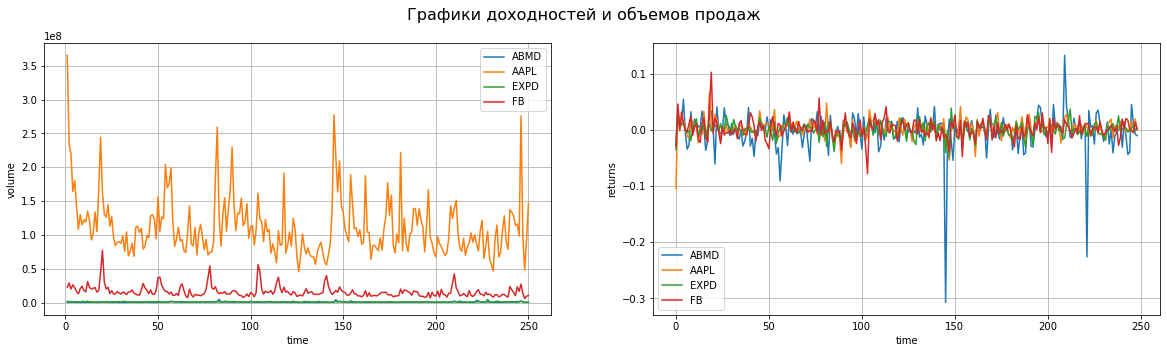

In [62]:
f = plt.figure(figsize=(20, 5))
ax1 = f.add_subplot(121)
f.suptitle('Графики доходностей и объемов продаж', fontsize=16)
#ax2 = f.add_subplot(122)

ax1=plt.grid()
ax1=plt.xlabel("time")
ax1=plt.ylabel("volume")
for stock in stocks_diff_sectors:
    ticker = volume[stock].to_list()
    periods = volume.index.to_list()
    ax1=plt.plot(periods, ticker)
ax1=plt.legend(labels=stocks_diff_sectors)

ax2 = f.add_subplot(122)

ax2=plt.grid()
ax2=plt.xlabel("time")
ax2=plt.ylabel("returns")
for stock in stocks_diff_sectors:
    ticker = log_returns[stock].to_list()
    periods = log_returns.index.to_list()
    ax2=plt.plot(periods, ticker)
ax2=plt.legend(labels=stocks_diff_sectors)
plt.show()


## 8. Исследовать зависимости (выборочно) между доходностями различных активов с помощью техники анализа зависимостей. Сделайте анализ зависимостей между парами активов для активов из одного производственного сектора и для активов из разных производственных секторов. Сделайте анализ зависимости (выборочно) между доходностями и объемами продаж одного актива. Рассмотрите активы из разных производственных секторов. 

#### Анализ зависимостей между парами активов для активов из одного производственного сектора:

In [28]:
def plot_correlations(log_ret1, ticker1, log_ret2, ticker2):
    plt.scatter(log_ret1, log_ret2, c = 'green')
    plt.xlabel(ticker1)
    plt.ylabel(ticker2)
    plt.show()
    print('Коэффициент корреляции: ' , np.corrcoef(log_ret1.astype(float), log_ret2.astype(float))[1][0])

Для начала будет интересно посмотреть на зависимости между доходностями для пары активов из сектора информационных технологий (отрасль - полупроводниковое оборудование). Рассмотрим компании ASML Holding (ASML) и Lam Research (LRCX).

In [29]:
plot_correlations(log_returns['LRCX'], 'LRSX', log_returns['ASML'], 'ASML')

KeyError: 'LRCX'

Далее рассмотрим пару компаний из коммуникационного сектора (отрасль - интерактивные медиа и услуги) - Alphabet Inc. (GOOG) и Facebook Inc. (FB).

In [30]:
plot_correlations(log_returns['GOOG'], 'GOOG', log_returns['FB'], 'FB')

KeyError: 'GOOG'

Итак, как видно по графикам, существует некоторая зависимость между доходностями компаний из одного сектора. Эта зависимость усиливается, если компании к тому же находятся в одной отрасли.

#### Анализ зависимостей между парами активов для активов из разных производственных секторов:

Теперь рассмотрим пару компаний из разных секторов - Facebook Inc. (FB) и Tesla (TSLA). Первая принадлежит к коммуникационному сектору, вторая к сектору товаров длительного пользования.

In [31]:
plot_correlations(log_returns['FB'], 'FB', log_returns['TSLA'], 'TSLA')

KeyError: 'TSLA'

График зависимости доходностей компаний PepsiCo, Inc. (PEP) и ASML Holding (ASML). PepsiCo - сектор потребительских товаров не длительного пользования, ASML - информационные технологии.

In [32]:
plot_correlations(log_returns['PEP'], 'PEP', log_returns['ASML'], 'ASML')

KeyError: 'PEP'

Как и следовало ожидать, коэффииценты корреляции между доходностями компаний из разных секторов очень низкие. Это означает, что зависимости между доходностями этих компаний нет.

#### Анализ зависимости между доходностями и объемами продаж одного актива:

In [33]:
volume = volume.loc[volume['Date'] != '2019-01-02'] #this is for dimensions of log_returns and volume to match

Компания Facebook:

In [ ]:
plot_correlations(log_returns['FB'], 'log_returns', volume['FB'], 'volume')

Компания  Lam Research:

In [ ]:
plot_correlations(log_returns['LRCX'], 'log_returns', volume['LRCX'], 'volume')

Компания Tesla:

In [ ]:
plot_correlations(log_returns['TSLA'], 'log_returns', volume['TSLA'], 'volume')

Итак, зависимостей между доходностями и объемами продаж не выявлено ни в одной из трех рассмотренных компаний.

#### Также интересно будет посмотреть на матрицу корреляции между несколькими активами из одного сектора:

Для анализа мы выбрали 10 компаний из сектора информационных технологий (отрасль - полупроводниковое оборудование): ASML Holding (ASML), Lam Research (LRCX), NVIDIA (NVDA), Broadcom Inc.(AVGO), Micron Technology (MU), Analog Devices (ADI), KLA Corporation (KLAC), Microchip Technology (MCHP), Marvell Technology Group (MRVL), Skyworks Solutions (SWKS).

In [ ]:
it_companies = log_returns[['ASML', 'LRCX', 'NVDA', 'AVGO', 'MU', 'ADI', 'KLAC', 'MCHP', 'MRVL', 'SWKS']]
it_companies.replace(0, 0.0001, inplace=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(it_companies.corr(), annot=True)
plt.show()

Как видно по матрице корреляции, минимальный коэффициент составляет 0.57, максимальный достигает значения 0.82. Это значит, что существуют зависимости между доходностями некоторых рассмотренных компаний из одного сектора.

#### Теперь посмотрим на матрицу корреляции между несколькими активами из разных отраслей:

Для анализа мы выбрали 10 компаний из различных секторов: Facebook Inc. (FB), Lam Research (LRCX), PepsiCo, Inc. (PEP), Verisk Analytics (VRSK), Liberty Broadband (LBRDA), Pool (POOL), J.B. Hunt Transport Services (JBHT), Alliant Energy (LNT), Hasbro (HAS), First Citizens BancShares (FCNCA).

In [ ]:
other_companies = log_returns[['FB', 'LRCX', 'PEP', 'VRSK', 'LBRDA', 'POOL', 'JBHT', 'LNT', 'HAS', 'FCNCA']]
other_companies.replace(0, 0.0001, inplace=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(other_companies.corr(), annot=True)
plt.show()

Как видно по матрице корреляции, минимальный коэффициент составляет 0.11, максимальный достигает значения 0.51. Это значит, что зависимостей между доходностями рассмотренных компаний из разных отраслей нет.